--- Case 1: Chirped Grating ---
Chirped Grating - Elapsed time: 0.32 seconds
Chirped Grating Score: 0.001103
Chirped Grating Centroid: 1.0296 µm

--- Case 2: 7.2 Period Grating ---
7.2 Period Grating - Elapsed time: 0.40 seconds
7.2 Period Grating Score: 0.000332
7.2 Period Grating Centroid: 1.0271 µm


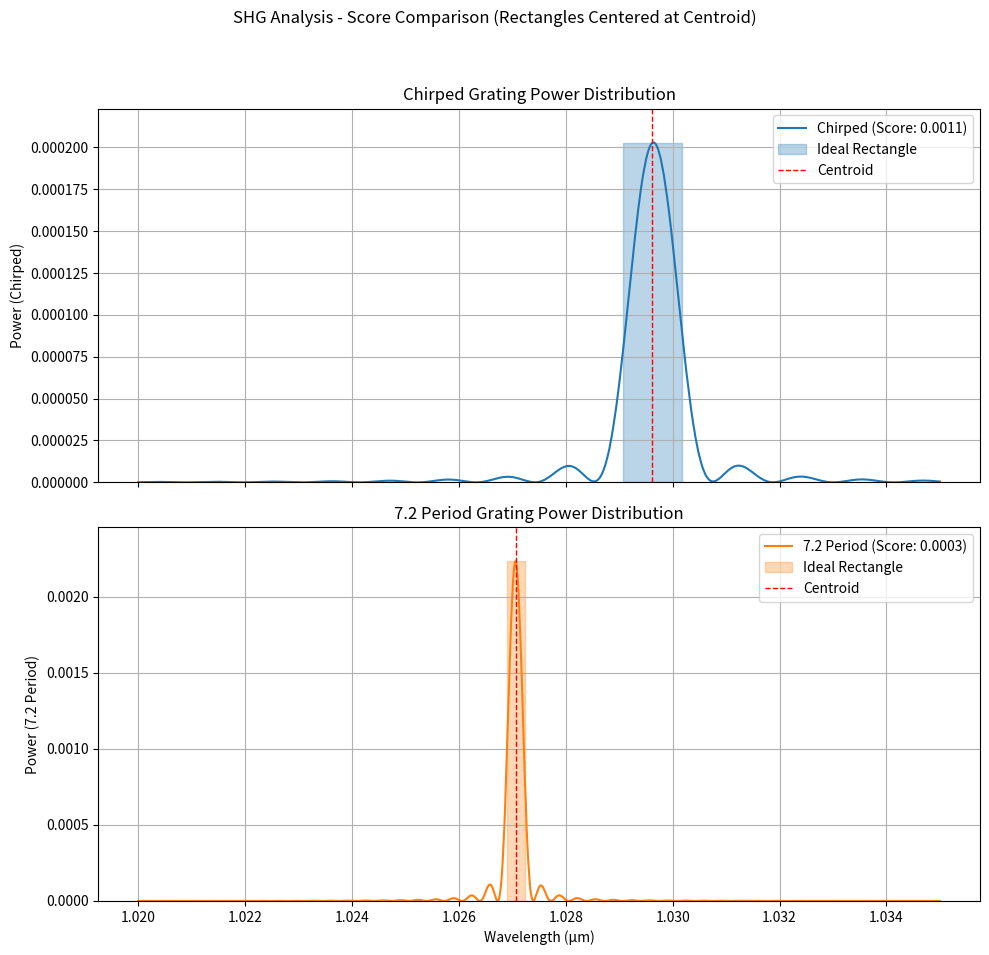

In [9]:
import jax.numpy as jnp
import timeit
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
from typing import List
import numpy as np


# ---------------------------------------------------------------------------
# 広帯域スコア計算関数
# ---------------------------------------------------------------------------
def calculate_broadband_score(wavelengths, power):
    wavelengths_jnp = jnp.array(wavelengths)
    power_jnp = jnp.array(power)
    if power_jnp.size == 0 or wavelengths_jnp.size != power_jnp.size:
        return jnp.array(0.0)
    peak_power = jnp.max(power_jnp)

    def calculate():
        total_area = jnp.trapezoid(power_jnp, wavelengths_jnp)
        return total_area / peak_power
    return jnp.where(peak_power <= 0, jnp.array(0.0), calculate())


# ---------------------------------------------------------------------------
# 重心計算関数
# ---------------------------------------------------------------------------
def calculate_centroid(wavelengths, power):
    """スペクトルの重心（Centroid）を計算します。"""
    wavelengths_jnp = jnp.array(wavelengths)
    power_jnp = jnp.array(power)

    peak_power = jnp.max(power_jnp)
    if peak_power <= 0:
        return jnp.mean(wavelengths_jnp)  # パワーがない場合は中央値を返す

    total_area = jnp.trapezoid(power_jnp, wavelengths_jnp)
    weighted_area = jnp.trapezoid(power_jnp * wavelengths_jnp, wavelengths_jnp)

    return weighted_area / total_area


# ---------------------------------------------------------------------------
# シミュレーション設定
# ---------------------------------------------------------------------------
num_domains = 1000
kappa_val = 1.031E-05
wavelengths_list = jnp.linspace(1.02, 1.035, 1000).tolist()
wavelengths_jnp = jnp.array(wavelengths_list)
T_dim: List[float] = [20, 70]
temp_idx_to_use = 0
fund_idx_to_use = 0

# ---------------------------------------------------------------------------
# Case 1: Chirped Grating の計算
# ---------------------------------------------------------------------------
print("--- Case 1: Chirped Grating ---")
grating_chirped = pp.chirped(600, [3.63], kappa_val, [0.0000005])
params_chirped = shg.Params(grating_dim=grating_chirped, T_dim=T_dim,
                            wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
start = timeit.default_timer()
eff_tensor_chirped = mgoslt.analyze(params_chirped)
stop = timeit.default_timer()
print(f"Chirped Grating - Elapsed time: {stop - start:.2f} seconds")
eff_complex_chirped = eff_tensor_chirped[temp_idx_to_use,
                                         fund_idx_to_use, :, 0, 0]
power_chirped = jnp.abs(eff_complex_chirped)**2
score_chirped = calculate_broadband_score(wavelengths_jnp, power_chirped)
centroid_chirped = calculate_centroid(wavelengths_jnp, power_chirped)  # 重心を計算
print(f"Chirped Grating Score: {score_chirped:.6f}")
print(f"Chirped Grating Centroid: {centroid_chirped:.4f} µm")

# ---------------------------------------------------------------------------
# Case 2: 7.2 Period Grating の計算
# ---------------------------------------------------------------------------
print("\n--- Case 2: 7.2 Period Grating ---")
grating_7_2 = pp.periodical(num_domains * 2, [7.2], kappa_val, 1/2)
params_7_2 = shg.Params(grating_dim=grating_7_2, T_dim=T_dim,
                        wavelength_dim=wavelengths_list, fund_power_dim=1, sh_power_dim=0)
start = timeit.default_timer()
eff_tensor_7_2 = mgoslt.analyze(params_7_2)
stop = timeit.default_timer()
print(f"7.2 Period Grating - Elapsed time: {stop - start:.2f} seconds")
eff_complex_7_2 = eff_tensor_7_2[temp_idx_to_use, fund_idx_to_use, :, 0, 0]
power_7_2 = jnp.abs(eff_complex_7_2)**2
score_7_2 = calculate_broadband_score(wavelengths_jnp, power_7_2)
centroid_7_2 = calculate_centroid(wavelengths_jnp, power_7_2)  # 重心を計算
print(f"7.2 Period Grating Score: {score_7_2:.6f}")
print(f"7.2 Period Grating Centroid: {centroid_7_2:.4f} µm")

# ---------------------------------------------------------------------------
# 結果のプロット (別々のグラフ + 重心中心の理想矩形)
# ---------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.suptitle(
    "SHG Analysis - Score Comparison (Rectangles Centered at Centroid)")

# --- Plot 1: Chirped Grating ---
p_max_chirped = jnp.max(power_chirped)
rect_start_chirped = centroid_chirped - (score_chirped / 2)  # 左端 = 重心 - 幅/2

ax1.plot(wavelengths_list, power_chirped,
         label=f"Chirped (Score: {score_chirped:.4f})", color='tab:blue')
rect1 = plt.Rectangle((float(rect_start_chirped), 0), float(score_chirped), float(p_max_chirped),  # type: ignore
                      color='tab:blue', alpha=0.3, label='Ideal Rectangle')
ax1.add_patch(rect1)
ax1.axvline(x=float(centroid_chirped), color='red', linestyle='--',
            linewidth=1, label='Centroid')  # 重心線を追加
ax1.set_ylabel("Power (Chirped)")
ax1.set_title("Chirped Grating Power Distribution")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, float(p_max_chirped) * 1.1 if p_max_chirped > 0 else 1)

# --- Plot 2: 7.2 Period Grating ---
p_max_7_2 = jnp.max(power_7_2)
rect_start_7_2 = centroid_7_2 - (score_7_2 / 2)  # 左端 = 重心 - 幅/2

ax2.plot(wavelengths_list, power_7_2,
         label=f"7.2 Period (Score: {score_7_2:.4f})", color='tab:orange')
rect2 = plt.Rectangle((float(rect_start_7_2), 0), float(score_7_2), float(p_max_7_2),  # type: ignore
                      color='tab:orange', alpha=0.3, label='Ideal Rectangle')
ax2.add_patch(rect2)
ax2.axvline(x=float(centroid_7_2), color='red', linestyle='--',
            linewidth=1, label='Centroid')  # 重心線を追加
ax2.set_xlabel("Wavelength (μm)")
ax2.set_ylabel("Power (7.2 Period)")
ax2.set_title("7.2 Period Grating Power Distribution")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, float(p_max_7_2) * 1.1 if p_max_7_2 > 0 else 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # type: ignore
plt.show()


# TODO: ここから下の指示にしたがった実装
# TODO: 周期分極反転構造を5つ連結した構造において、もっとも分布がフラットになる条件をオプティマイザで求める
# 以下のduties5つとperiod5つ、合計10個がオプティマイザで求めるパラメータ
duties = [1/2, 1/3, 1/4, 1/5, 1/6]
period = [7.2, 8.0, 9.0, 10.0, 11.0]
gratings = [pp.periodical(num_domains * 2, [p], kappa_val, d)
            for d, p in zip(duties, period)]